### Building chatbot with multiple tools using LangGraph

### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions 

# here is the link for langchain tools which we can use it in langGraph aswell: 

## https://python.langchain.com/docs/integrations/tools/

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [7]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
wiki_wrapper_arxiv = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper_arxiv)
print(wiki.name)

wikipedia


In [10]:
wiki.invoke("What is Machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [22]:
from dotenv import load_dotenv

load_dotenv()

import os

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [23]:
# Tavily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

## Creating tools


In [24]:
tools = [arxiv, wiki, tavily]

In [26]:
## initializing the LLM model

from langchain_groq import ChatGroq
LLM = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = LLM.bind_tools(tools)

In [27]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage 
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jmq26937b', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 554, 'total_tokens': 574, 'completion_time': 0.023993037, 'prompt_time': 0.033949571, 'queue_time': 0.054182189, 'total_time': 0.057942608}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cbc3c953-70c1-4e68-abf3-3609d3f1165b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'jmq26937b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 554, 'output_tokens': 20, 'total_tokens': 574})

In [28]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 't7mmrsgs5',
  'type': 'tool_call'}]

In [31]:
# state schema
from pydantic import BaseModel
from langgraph.graph.message import add_messages
from typing import Annotated

class State(BaseModel):
    messages: Annotated[list, add_messages]

In [33]:
# Creating entire chatbot

from IPython.display import display , Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}

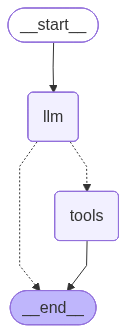

In [35]:
# build graph

builder = StateGraph(State)

builder.add_node("llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, 'llm')
builder.add_conditional_edges('llm', tools_condition)
builder.add_edge('tools', END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
message = graph.invoke({"messages": HumanMessage(content="what is ATTENTION IS ALL YOU NEED paper about?")})

for msg in message['messages']:
    msg.pretty_print()

================================ Human Message =================================

what is ATTENTION IS ALL YOU NEED paper about?
================================== Ai Message ==================================
Tool Calls:
  arxiv (3gsak1g30)
 Call ID: 3gsak1g30
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [44]:
# It can even work via paper ID
message = graph.invoke({"messages": HumanMessage(content="1706.03762")})

for msg in message['messages']:
    msg.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (brqxc94jp)
 Call ID: brqxc94jp
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [45]:
message = graph.invoke({"messages": HumanMessage(content="Provide me the recent AI news form oct 1 2025")})

for msg in message['messages']:
    msg.pretty_print()

================================ Human Message =================================

Provide me the recent AI news form oct 1 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (wy44swp2c)
 Call ID: wy44swp2c
  Args:
    query: AI news October 1 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Daily Digest on AI and Emerging Technologies (2 October 2025)", "url": "https://www.cgspam.org/daily-digest-on-ai-and-emerging-technologies-2-october-2025/", "content": "(AI Insider – 1 October 2025) OpenAI has signed agreements with Samsung Electronics and SK Hynix to supply high-bandwidth memory chips and build AI data centers in South Korea as part of its $500 billion Stargate infrastructure initiative with Oracle and SoftBank. The letters of intent were finalized in Seoul following a meeting between Sam Altman, President Lee Jae-myung, Jay

In [47]:
message = graph.invoke({"messages": HumanMessage(content="What is Machine Learning?")})

for msg in message['messages']:
    msg.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (jn9s7vj9b)
 Call ID: jn9s7vj9b
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
